In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, StackingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import plot_roc_curve
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

### deal with some left over from preprocessing

In [7]:
df = pd.read_csv('data/combined.csv')

In [8]:
np.unique(df.latest_review_year, return_counts=True)

(array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
        2019, 2020, 2021, 2022], dtype=int64),
 array([   4,   16,   35,   67,   98,  158,  203,  262,  278,  343,  402,
         709,  928, 4122, 1189], dtype=int64))

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8814 entries, 0 to 8813
Columns: 719 entries, business_id to Wraps
dtypes: float64(10), int64(668), object(41)
memory usage: 48.3+ MB


In [10]:
le = LabelEncoder()
df['name'] = le.fit_transform(df['name'])
df['city'] = le.fit_transform(df['city'])
df['postal_code'] = le.fit_transform(df['postal_code'])

In [11]:
df = df[df['RestaurantsPriceRange2'] != 'None']
df['RestaurantsPriceRange2'] = df['RestaurantsPriceRange2'].astype(float)
df = df.dropna(subset='RestaurantsPriceRange2')
df['RestaurantsPriceRange2'] = df['RestaurantsPriceRange2'].astype(int)

In [12]:
## True/False/None datatype issue: 'RestaurantsDelivery', 'BusinessAcceptsCreditCards', 'RestaurantsTakeOut', 'RestaurantsReservations', 'RestaurantsGoodForGroups'
true_false_col = ['RestaurantsDelivery', 'BusinessAcceptsCreditCards', 'RestaurantsTakeOut', 'RestaurantsReservations', 'RestaurantsGoodForGroups']

def tf_issue(col_li, df):

    for col in col_li:
        df[col] = df[col].astype('|S')
        df[col] = df[col].apply(lambda line: b'False' if line == b'nan' else line)
        df[col] = df[col].apply(lambda line: b'False' if line == b'None' else line)
        df[col] = LabelEncoder().fit_transform(df[col])
        df[col] = df[col].astype(int)

tf_issue(true_false_col, df)

In [13]:
# Weird u in the string
weird_u = ['WiFi', 'Alcohol', 'RestaurantsAttire', 'NoiseLevel', 'Smoking']

def u_issue(col_li, df):

    for col in col_li:
        df[col] = df[col].apply(lambda line: 'none' if type(line) == float else (line.split("\'")[1].lower() if len(line.split("\'")) == 3 else line.split("\'")[0].lower()))
        df[col] = LabelEncoder().fit_transform(df[col])
        df[col] = df[col].astype(int)

u_issue(weird_u, df)

In [14]:
# AcceptsInsurance, Open24Hours RestaurantsCounterService, has no useful value
# DietaryRestrictions have only 5 records
drop_col = ['business_id', 'AcceptsInsurance', 'Open24Hours', 'DietaryRestrictions', 'RestaurantsCounterService', 'Caters', 'HasTV', 'GoodForKids', 'DogsAllowed', 
            'HappyHour', 'WheelchairAccessible', 'OutdoorSeating', 'BikeParking', 'RestaurantsAttire', 'Ambience', 'Smoking', 'Music', 'GoodForDancing', 
            'BusinessAcceptsBitcoin', 'CoatCheck', 'BestNights', 'Corkage', 'BYOBCorkage', 'BYOB', 'AgesAllowed', 'ByAppointmentOnly', 'RestaurantsTableService',
            'DriveThru', 'BusinessParking', 'GoodForMeal']

df.drop(columns = drop_col, inplace=True)

In [15]:
# delete columns only with one unique values
del_col = []

for i in df.columns:
    if df[i].nunique() <= 1:
        del_col.append(i)

df.drop(columns = del_col, inplace=True)

In [16]:
df = df.dropna(axis = 0)

### Modeling

In [140]:
test_set = df[(df.latest_review_year == 2022) & (df.is_open == 1)]
test_set.is_open.value_counts()

1    1012
Name: is_open, dtype: int64

In [141]:
training_set = df.drop(df[df.latest_review_year == 2022].index)
training_set.is_open.value_counts()

1    4274
0    2610
Name: is_open, dtype: int64

In [142]:
# prepare data for modeling
X = training_set.drop(columns=['is_open', 'latest_review_year'])
y = training_set['is_open']

In [143]:
models = [LogisticRegression(),
          KNeighborsClassifier(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          GradientBoostingClassifier(),
          xgb.XGBClassifier()]

scores = []
seed = [0, 123, 456, 789, 519]
for ml in models:
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=seed[i])
        scaler = preprocessing.MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        ml.fit(X_train, y_train)
        y_pred = ml.predict(X_test)
        scores.append(recall_score(y_pred, y_test))
    print(ml, 'average recall score:', round(sum(scores)/len(scores), 4))

LogisticRegression() average recall score: 0.7512
KNeighborsClassifier() average recall score: 0.7334
DecisionTreeClassifier() average recall score: 0.7296
RandomForestClassifier() average recall score: 0.733
GradientBoostingClassifier() average recall score: 0.7374
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) average recall score: 0.7429


### hyperparameter tuning (LR)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

In [157]:
params = {'penalty': ['none', 'l2', 'l1', 'elasticnet'],
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'C': [0.01, 0.1, 1.0, 10, 100]}

model = LogisticRegression()
clf = GridSearchCV(model, params, n_jobs=5, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)
clf.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [160]:
LR_model = LogisticRegression(C=0.1, penalty='l2', solver='newton-cg')
LR_model.fit(X_train, y_train)

y_pred = LR_model.predict(X_test)

print('**Accuracy Score : ', round(accuracy_score(y_test,y_pred), 4))
print('Precision Score : ', round(precision_score(y_test,y_pred), 4))
print('Recall Score : ', round(recall_score(y_test,y_pred), 4))
print('F1 Score : ', round(f1_score(y_test,y_pred), 4))

confusion_matrix(y_test, y_pred)

**Accuracy Score :  0.7255
Precision Score :  0.7326
Recall Score :  0.8769
F1 Score :  0.7983


array([[251, 273],
       [105, 748]], dtype=int64)

In [161]:
X_for_sample = test_set.drop(columns=['is_open','latest_review_year'])
y_for_sample = test_set['is_open']

y_pred_sample = LR_model.predict(X_for_sample)

print('**Accuracy Score : ', round(accuracy_score(y_for_sample,y_pred_sample), 4))
print('Precision Score : ', round(precision_score(y_for_sample,y_pred_sample), 4))
print('Recall Score : ', round(recall_score(y_for_sample,y_pred_sample), 4))
print('F1 Score : ', round(f1_score(y_for_sample,y_pred_sample), 4))

print(confusion_matrix(y_for_sample,y_pred_sample))

print(classification_report(y_for_sample, y_pred_sample))

**Accuracy Score :  0.9239
Precision Score :  1.0
Recall Score :  0.9239
F1 Score :  0.9605
[[  0   0]
 [ 77 935]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.92      0.96      1012

    accuracy                           0.92      1012
   macro avg       0.50      0.46      0.48      1012
weighted avg       1.00      0.92      0.96      1012



In [166]:
importance = LR_model.coef_
importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': LR_model.coef_[0],
    'abs_imp': abs(LR_model.coef_[0])
})
importance = importance.sort_values(by='abs_imp', ascending=False)

In [169]:
importance.Attribute.head(20)

3                     latitude
9             reviews_per_week
13         RestaurantsDelivery
225            Hotels & Travel
357                   Southern
4                    longitude
11                std_of_stars
398                 Vietnamese
467                    Chinese
199                    Grocery
231                     Indian
380                       Thai
110               Chicken Shop
224                     Hotels
503                  Fast Food
19     RestaurantsReservations
640                 Vegetarian
26                      Friday
375         Tapas/Small Plates
184                     French
Name: Attribute, dtype: object

In [170]:
tmp = importance.head(20)
tmp = tmp.sort_values(by='Importance', ascending=False)

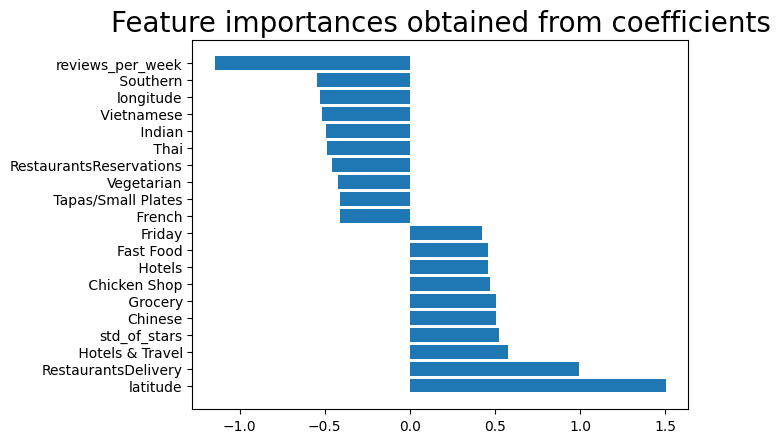

In [178]:
plt.barh(tmp['Attribute'], tmp['Importance'])
plt.title('Feature importances obtained from coefficients', size=20)
plt.yticks(rotation='horizontal')
plt.show()